# Predictions

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error as rmse
from xgboost import XGBRegressor

from feature_engineering import generate_event_features

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.3f}'.format)

## 1. Data import

In [3]:
DATA_DIR = 'data'

In [4]:
TRAIN_FILE_NAME = 'train_dev.csv'

In [5]:
train_file_path = os.path.join(DATA_DIR, TRAIN_FILE_NAME)

In [6]:
df = pd.read_csv(train_file_path).set_index('user_id')

In [7]:
df.shape

(4862, 36)

In [8]:
df.head()

,entry_point=android,country_e,battles_won_d0,battles_won_d1,battles_won_d3,battles_won_d7,battles_lost_d0,battles_lost_d1,battles_lost_d3,battles_lost_d7,session_time_d0,session_time_d1,session_time_d3,session_time_d7,inactive_d1,n_active_days,wealth_on_login_max_d0,wealth_on_login_max_d1,wealth_on_login_max_d3,wealth_on_login_max_d7,finish_quest_sum_d0,finish_quest_sum_d1,finish_quest_sum_d3,finish_quest_sum_d7,level_up_max_d0,level_up_max_d1,level_up_max_d3,level_up_max_d7,payment_sum_d0,payment_sum_d1,payment_sum_d3,payment_sum_d7,wealth_on_login_max_d0=802,wealth_on_login_max_d7=802,segment,ltv_30
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,3,47.000,172.000,214.000,232.000,1.000,1.000,2.000,8.000,341.000,761.000,1192.000,1921.000,0,8,20695.000,186656.000,249194.000,419827.000,270,400,1150,1740,10,17,17,19,122.255,195.608,195.608,391.363,0,0,TRAIN,1468.187
2,1,8,0.000,34.000,69.000,153.000,0.000,1.000,1.000,10.000,33.000,188.000,598.000,1453.000,0,8,806.000,9045.000,28680.000,90769.000,0,0,390,1230,2,9,14,15,0.000,0.000,30.648,30.648,0,0,TRAIN,619.849
3,1,3,41.000,65.000,78.000,113.000,13.000,20.000,20.000,23.000,505.000,883.000,1106.000,1567.000,0,8,4684.000,15214.000,32761.000,58584.000,230,340,600,970,9,13,14,16,0.000,48.902,48.902,73.353,0,0,TRAIN,97.804
4,1,13,26.000,47.000,89.000,125.000,1.000,1.000,3.000,3.000,126.000,222.000,631.000,860.000,0,7,8940.000,12900.000,40856.000,82547.000,100,260,780,1240,9,9,14,16,0.000,0.000,71.662,71.662,0,0,TRAIN,71.662
5,1,8,44.000,67.000,94.000,127.000,2.000,2.000,2.000,2.000,535.000,1075.000,1766.000,2523.000,0,8,17689.000,25283.000,32983.000,39425.000,350,590,980,1830,9,10,10,10,0.000,0.000,0.000,0.000,0,0,TRAIN,0.000


## 2. Datasets preparation

In [9]:
TARGET = 'ltv_30'

In [10]:
features = [x for x in df.columns.tolist() if x not in ['segment', TARGET]]

In [11]:
train_df = df[df['segment'] == 'TRAIN']
dev_df = df[df['segment'] == 'DEV']

In [12]:
print(train_df.shape)
print(dev_df.shape)

(3889, 36)
(973, 36)


In [13]:
X_train = train_df[features].values
y_train = train_df[TARGET].values

X_dev = dev_df[features].values
y_dev = dev_df[TARGET].values

In [14]:
print(X_train.shape)
print(y_train.shape)
print()
print(X_dev.shape)
print(y_dev.shape)

(3889, 34)
(3889,)

(973, 34)
(973,)


## 3. Best model training
## `RMSE_train = 333.95`
## `RMSE_dev = 499.03`
### 3.1. Training

In [15]:
XGB_HYPERPARAMS_FIXED = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'n_jobs': -1,
    
    'random_state': 42,
}

In [16]:
BEST_HP = {
    'n_estimators': 525,
    'max_depth': 4,
    'learning_rate': 0.01782103450973774,
    'subsample': 0.8927219297311951,
    'colsample_bytree': 0.5390163942734214,
    'min_child_weight': 3.7191341096707813,
    'gamma': 1.304456011005572,
    'reg_alpha': 5.396467723652694,
    'reg_lambda': 9.40505257447381,
    # 'rmse_train': 333.9508387041941,
    # 'rmse_dev': 499.0340940255368
}

In [17]:
hp = XGB_HYPERPARAMS_FIXED | BEST_HP

In [18]:
best_model = XGBRegressor(**hp)

In [19]:
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5390163942734214, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=1.304456011005572, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01782103450973774,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=3.7191341096707813, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=525,
             n_jobs=-1, num_parallel_tree=None, ...)

In [20]:
df['y_pred'] = best_model.predict(df[features].values)

In [21]:
df['error'] = df[TARGET] - df['y_pred']

In [22]:
df.loc[train_df.index][['ltv_30', 'y_pred']].head(10)

,ltv_30,y_pred
user_id,,
1,1468.187,1196.137
2,619.849,201.525
3,97.804,188.859
4,71.662,63.664
5,0.000,215.946
6,135.186,226.795
7,269.157,430.284
8,1297.324,1467.296
9,1226.520,569.036


In [23]:
df.loc[dev_df.index][['ltv_30', 'y_pred']].head(10)

,ltv_30,y_pred
user_id,,
10,3535.528,4035.029
23,24.022,346.412
30,831.775,100.427
31,1127.739,519.336
32,263.184,393.976
34,919.507,2171.681
35,383.766,292.619
40,81.436,667.662
43,2969.791,2711.189


In [24]:
print(df.loc[train_df.index]['error'].mean())
print(df.loc[dev_df.index]['error'].mean())

2.897330392026209
-23.287100958842533


### 3.2. Error plots

In [25]:
def drop_outliers(s: pd.Series) -> pd.Series:
    q1, q3 = s.quantile([0.25, 0.75])

    iqr = q3 - q1

    return s[(s > q1 - 1.5 * iqr) & (s < q3 + 1.5 * iqr)]


def drop_tails(s: pd.Series, min_v: float=None, max_v: float=None) -> pd.Series:
    if min_v is not None:
        s = s[s >= min_v]

    if max_v is not None:
        s = s[s <= max_v]

    return s

In [26]:
dev_errors = df.loc[dev_df.index]['error']

dev_errors_zero = dev_errors[dev_df[TARGET] == 0]
dev_errors_non_zero = dev_errors[dev_df[TARGET] != 0]

In [27]:
print(len(dev_errors_zero))
print(len(dev_errors_non_zero))

623
350


In [28]:
print(dev_errors_zero.abs().mean())
print(dev_errors_non_zero.abs().mean())

3.174846416384125
285.0564045549141


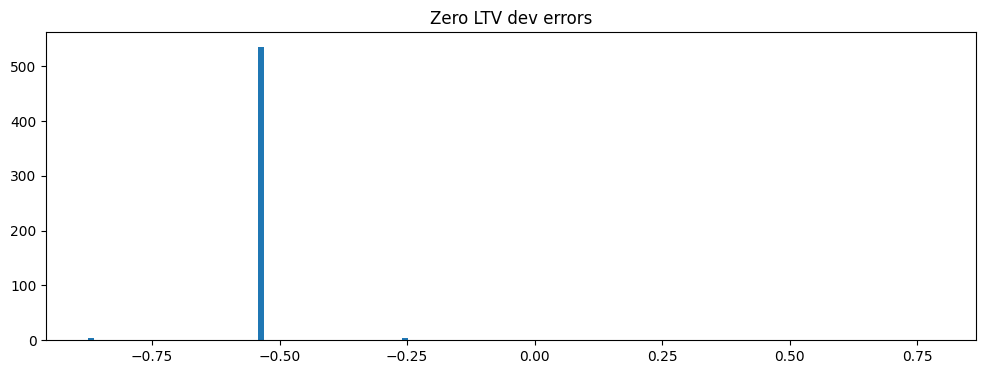

In [29]:
hist, bins = np.histogram(drop_tails(dev_errors_zero, min_v=-1, max_v=1), bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12, 4))
plt.bar(center, hist, align='center', width=width)
plt.title('Zero LTV dev errors')
plt.show()

In [30]:
df.loc[dev_errors_zero.index][['ltv_30', 'y_pred']].head(10)

,ltv_30,y_pred
user_id,,
71,0.000,1.338
162,0.000,0.529
171,0.000,61.182
242,0.000,0.529
253,0.000,0.529
254,0.000,0.529
264,0.000,0.529
270,0.000,0.529
272,0.000,0.529


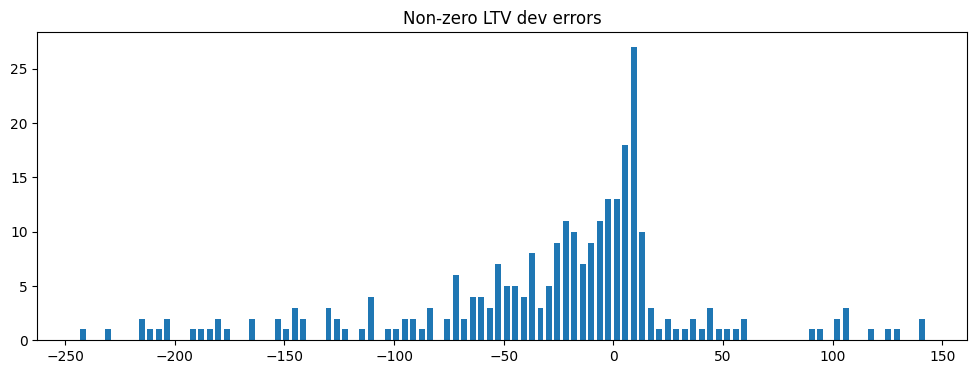

In [31]:
hist, bins = np.histogram(drop_outliers(dev_errors_non_zero), bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12, 4))
plt.bar(center, hist, align='center', width=width)
plt.title('Non-zero LTV dev errors')
plt.show()

In [32]:
df.loc[dev_errors_non_zero.index][['ltv_30', 'y_pred']].head(10)

,ltv_30,y_pred
user_id,,
10,3535.528,4035.029
23,24.022,346.412
30,831.775,100.427
31,1127.739,519.336
32,263.184,393.976
34,919.507,2171.681
35,383.766,292.619
40,81.436,667.662
43,2969.791,2711.189


## 4. Test set prediction
### 4.1. Dataset import

In [33]:
TEST_USERS_FILE_NAME = 'user_profile_test.csv'
TEST_EVENTS_FILE_NAME = 'events_test.csv'

In [34]:
test_users_file_path = os.path.join(DATA_DIR, TEST_USERS_FILE_NAME)
test_events_file_path = os.path.join(DATA_DIR, TEST_EVENTS_FILE_NAME)

In [35]:
test_df = pd.read_csv(test_users_file_path).set_index('user_id')

In [36]:
test_events_df = pd.read_csv(test_events_file_path)

In [37]:
test_df.shape

(604, 3)

In [38]:
test_events_df.shape

(57076, 4)

### 4.2. Preprocessing

In [39]:
test_df['reg_ts'] = pd.to_datetime(test_df['reg_ts'], unit='s')

In [40]:
test_events_df['event_ts'] = pd.to_datetime(test_events_df['event_ts'], unit='s')

In [41]:
test_df['entry_point=android'] = (test_df['entry_point'] == 'android').astype(int)

In [42]:
COUNTRY_RANK_DICT = {
    'CH': 1,
    'GB': 2,
    'US': 3,
    'DE': 4,
    'RO': 5,
    'CA': 6,
    'AU': 7,
    'PL': 8,
    'IT': 9,
    'ES': 10,
    'FR': 11,
    'ZA': 12,
    # 'OTHER': 13,
    'TR': 14,
    'BR': 15,
    'CL': 16,
    'AR': 17,
    'KZ': 18,
    'IN': 19,
    'PK': 20,
    'MX': 21
}

In [43]:
test_df['country_e'] = test_df['country'].map(COUNTRY_RANK_DICT).fillna(13).astype(int)

In [44]:
test_df = test_df.join(generate_event_features(test_df, test_events_df), how='left')

## 4.3. Prediction

In [45]:
X_test = test_df[features].values

In [46]:
test_df['target'] = best_model.predict(X_test)

### 4.4. Export

In [47]:
EXPORT_FILE_NAME = 'user_profile_test_export.csv'

In [48]:
export_file_path = os.path.join(DATA_DIR, EXPORT_FILE_NAME)

In [49]:
test_df[['target']].sort_index().to_csv(export_file_path)